# Prediction Part

### What we'll do here
- Set up the environment and imports
- Load and prepare data
- Cluster stations and aggregate demand
- Train and visualize forecasts
- Evaluate metrics and rebalancing

### How to run
1. Make sure the data files are in the data folder.
2. Run cells top-to-bottom.

### Table of Contents
- [2.1 Imports](#21-imports)
- [2.2 Load data](#22-load-data)
- [2.3 Spatial clustering (K=24)](#23-spatial-clustering-k24)
- [2.4 Elbow curve choice](#24-elbow-curve-choice)
- [2.5 Aggregate hourly demand](#25-aggregate-hourly-demand)
- [2.6 Modeling setup](#26-modeling-setup)
- [2.7 Forecast zoom](#27-forecast-zoom)
- [2.8 Rolling 24h forecast](#28-rolling-24h-forecast)
- [2.9 Metrics snapshots](#29-metrics-snapshots)
- [2.10 Rebalancing analysis](#210-rebalancing-analysis)


### 2.1 Imports

Minimal imports and configuration for clustering and forecasting.


In [53]:
# Imports and configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path

# Configuration
DATA_PATH = Path("../data/trips_2018.csv")
TABLES = Path("./TABLES")
TABLES.mkdir(exist_ok=True)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.titlesize': 14})

### 2.2 Load data

Read station coordinates and streamed trip data for aggregation.


### 2.3 Spatial clustering (K=24)

Fit K-Means on station coordinates and label clusters.


In [54]:
# Load station coordinates and fit KMeans (K=24)
print("Step 1: Loading station coordinates for clustering...")

station_coords = {}
chunksize = 500_000
for chunk in pd.read_csv(
    DATA_PATH,
    chunksize=chunksize,
    usecols=['start_station_id', 'start_station_latitude', 'start_station_longitude'],
):
    chunk = chunk.dropna().drop_duplicates('start_station_id')
    for _, row in chunk.iterrows():
        sid = int(row['start_station_id'])
        if sid not in station_coords:
            station_coords[sid] = (row['start_station_latitude'], row['start_station_longitude'])

stations_df = pd.DataFrame.from_dict(station_coords, orient='index', columns=['lat', 'lon'])
stations_df.index.name = 'station_id'
print(f"Found {len(stations_df)} unique stations.")

K = 24
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
stations_df['cluster'] = kmeans.fit_predict(stations_df[['lat', 'lon']])

# Save cluster mapping
cluster_map = stations_df[['cluster']].reset_index().rename(columns={'index': 'station_id'})
cluster_map.to_csv(TABLES / 'cluster_map.csv', index=False)
print(f"Saved cluster_map.csv with {len(cluster_map)} rows.")


Step 1: Loading station coordinates for clustering...
Found 818 unique stations.
Saved cluster_map.csv with 818 rows.


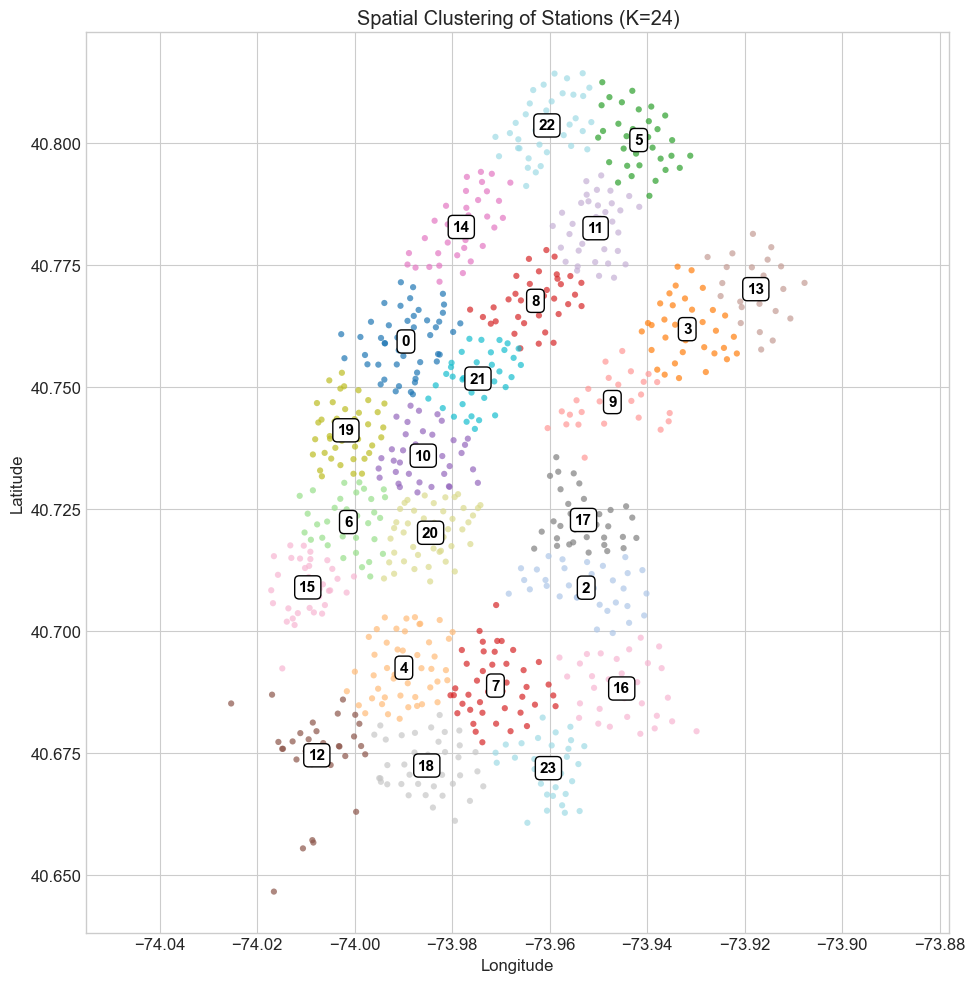

In [55]:
# --- VISUALIZATION: SPATIAL CLUSTERING ---


# Filter data to only include NYC area
nyc_stations = stations_df[
    (stations_df['lat'] > 40.60) & (stations_df['lat'] < 40.90) &
    (stations_df['lon'] > -74.05) & (stations_df['lon'] < -73.85)
]

plt.figure(figsize=(10, 10)) # Bigger size to accommodate labels

# Plot the points
plt.scatter(nyc_stations['lon'], nyc_stations['lat'], c=nyc_stations['cluster'], 
            cmap='tab20', s=20, alpha=0.7, edgecolor='none')


# We group by cluster to find the average lat/lon (the center) of each group
cluster_centers = nyc_stations.groupby('cluster')[['lat', 'lon']].mean()

# Annotate each cluster center with its cluster ID
for cluster_id, row in cluster_centers.iterrows():
    plt.text(
        row['lon'], row['lat'],     
        str(cluster_id),            
        fontsize=11, 
        weight='bold',
        color='black',
        ha='center', va='center',   
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=1)
    )

plt.title(f"Spatial Clustering of Stations (K={K})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal') 

plt.tight_layout()
plt.show()

### 2.4 Elbow curve choice

Check inertia across K to see the elbow point.


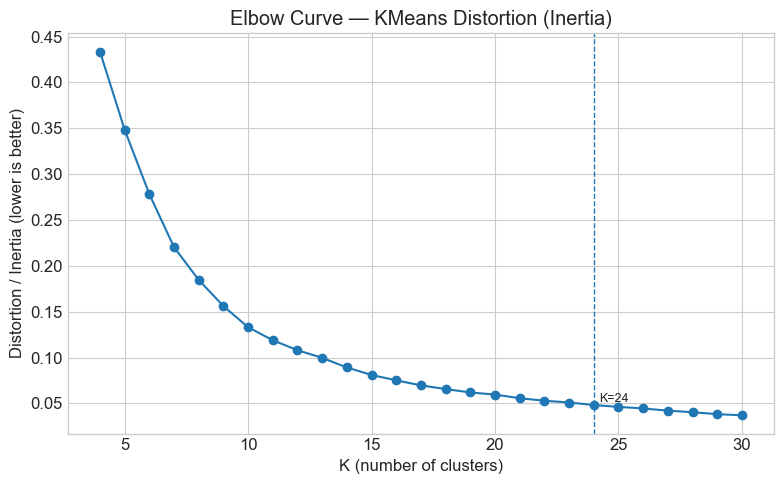

,K,inertia
0,4,0.433705
1,5,0.348407
2,6,0.278208
3,7,0.220379
4,8,0.184651
5,9,0.156198
6,10,0.133067
7,11,0.118914
8,12,0.108069
9,13,0.099711


In [56]:
# Elbow curve to inspect inertia across K values
lat0 = float(station_master["lat"].mean())
X = np.column_stack([
    station_master["lat"].to_numpy(),
    station_master["lon"].to_numpy() * np.cos(np.deg2rad(lat0)),
])

K_VALUES = list(range(4, 31))  
inertias = []
for K in K_VALUES:
    km = KMeans(n_clusters=K, n_init=10, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_) 

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(K_VALUES, inertias, marker="o")
ax.set_title("Elbow Curve — KMeans Distortion (Inertia)")
ax.set_xlabel("K (number of clusters)")
ax.set_ylabel("Distortion / Inertia (lower is better)")

k_mark = 24
if k_mark in K_VALUES:
    ax.axvline(k_mark, linestyle="--", linewidth=1)
    ax.text(k_mark + 0.2, np.interp(k_mark, K_VALUES, inertias),
            f"K={k_mark}", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

display(pd.DataFrame({"K": K_VALUES, "inertia": inertias}).head(25))

### 2.5 Aggregate hourly demand

Stream trips and aggregate pickups/dropoffs by cluster.


In [57]:
# Aggregate hourly pickups/dropoffs by cluster
station_to_cluster = stations_df['cluster'].to_dict()

pickup_counts = {}
dropoff_counts = {}

for chunk in pd.read_csv(
    DATA_PATH,
    chunksize=chunksize,
    usecols=['starttime', 'stoptime', 'start_station_id', 'end_station_id'],
):
    chunk['start_hour'] = pd.to_datetime(chunk['starttime']).dt.floor('h')
    chunk['end_hour'] = pd.to_datetime(chunk['stoptime']).dt.floor('h')
    chunk['start_cluster'] = chunk['start_station_id'].map(station_to_cluster)
    chunk['end_cluster'] = chunk['end_station_id'].map(station_to_cluster)

    for (ts, cid), count in chunk.groupby(['start_hour', 'start_cluster']).size().items():
        pickup_counts[(ts, cid)] = pickup_counts.get((ts, cid), 0) + count
    for (ts, cid), count in chunk.groupby(['end_hour', 'end_cluster']).size().items():
        dropoff_counts[(ts, cid)] = dropoff_counts.get((ts, cid), 0) + count


# Convert dictionaries to DataFrames
### Trip timeline
df_pick = pd.Series(pickup_counts).reset_index()
df_pick.columns = ['ts', 'cluster_id', 'pickups']

df_drop = pd.Series(dropoff_counts).reset_index()
df_drop.columns = ['ts', 'cluster_id', 'dropoffs']

df_hourly = pd.merge(df_pick, df_drop, on=['ts', 'cluster_id'], how='outer').fillna(0)
df_hourly['cluster_id'] = df_hourly['cluster_id'].astype(int)
df_hourly = df_hourly.sort_values(['cluster_id', 'ts'])

# Reindex to fill missing hours
full_idx = pd.date_range(start=df_hourly['ts'].min(), end=df_hourly['ts'].max(), freq='h')
mux = pd.MultiIndex.from_product([df_hourly['cluster_id'].unique(), full_idx], names=['cluster_id', 'ts'])
df_hourly = df_hourly.set_index(['cluster_id', 'ts']).reindex(mux, fill_value=0).reset_index()

print(df_hourly.head())


   cluster_id                  ts  pickups  dropoffs
0           0 2018-01-01 00:00:00     15.0       5.0
1           0 2018-01-01 01:00:00     17.0      19.0
2           0 2018-01-01 02:00:00      8.0      11.0
3           0 2018-01-01 03:00:00      9.0       9.0
4           0 2018-01-01 04:00:00      6.0       3.0


### 2.6 Modeling setup

Baseline ridge on the highest-demand cluster.


In [58]:
# Simple ridge baseline on top-demand cluster
target_cluster = df_hourly.groupby('cluster_id')['pickups'].sum().idxmax()
print(f"Modeling representative cluster: {target_cluster}")

data = df_hourly[df_hourly['cluster_id'] == target_cluster].copy()
data = data.set_index('ts').sort_index()

# Lags and calendar features
data['lag_1h'] = data['pickups'].shift(1)
data['lag_24h'] = data['pickups'].shift(24)
data['lag_168h'] = data['pickups'].shift(168)

data['hour_of_day'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

data = data.dropna()

# Train = Jan–Oct, Test = Nov–Dec
train_mask = data.index.month <= 10
test_mask = data.index.month > 10

X_train = data.loc[train_mask, ['lag_1h', 'lag_24h', 'lag_168h', 'is_weekend']]
y_train = data.loc[train_mask, 'pickups']
y_train_drop = data.loc[train_mask, 'dropoffs'] 

X_test = data.loc[test_mask, ['lag_1h', 'lag_24h', 'lag_168h', 'is_weekend']]
y_test = data.loc[test_mask, 'pickups']
y_test_drop = data.loc[test_mask, 'dropoffs']

# Fit ridge models for pickups/dropoffs
model_pickups = Ridge(alpha=1.0)
model_pickups.fit(X_train, y_train)

model_dropoffs = Ridge(alpha=1.0)
model_dropoffs.fit(X_train, y_train_drop) 

# Predictions
x_test = X_test

y_pred = model_pickups.predict(x_test)
y_pred = np.maximum(y_pred, 0) 

y_pred_drop = model_dropoffs.predict(x_test)
y_pred_drop = np.maximum(y_pred_drop, 0)

# Quick metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, R2: {r2:.3f}")


Modeling representative cluster: 0
RMSE: 87.34, R2: 0.794


### 2.7 Forecast zoom

One-week zoom of actual vs predicted demand.


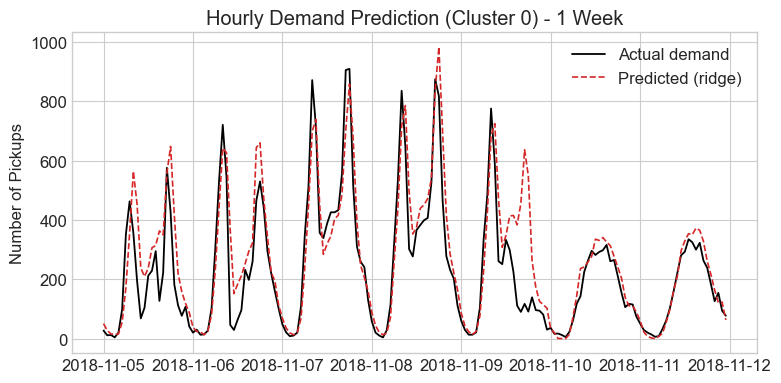

In [59]:
# --- VISUALIZATION: PREDCITION MODEL ---
zoom_start = '2018-11-05' 
zoom_end = '2018-11-12'
zoom_mask = (y_test.index >= zoom_start) & (y_test.index < zoom_end)

plt.figure(figsize=(8, 4))
TRUTH_STYLE = {"color": "black", "linewidth": 1.3, "label": "Actual demand"}
PRED_STYLE = {"color": "tab:red", "linestyle": "--", "linewidth": 1.2, "label": "Predicted (ridge)"}
plt.plot(y_test.index[zoom_mask], y_test[zoom_mask], **TRUTH_STYLE)
plt.plot(y_test.index[zoom_mask], y_pred[zoom_mask], **PRED_STYLE)
plt.title(f"Hourly Demand Prediction (Cluster {target_cluster}) - 1 Week")
plt.ylabel("Number of Pickups")
plt.legend()
plt.tight_layout()
plt.show()


### 2.8 Rolling 24h forecast

Sequential 24-hour forecasting per cluster to get comparable results with the exploratory part.


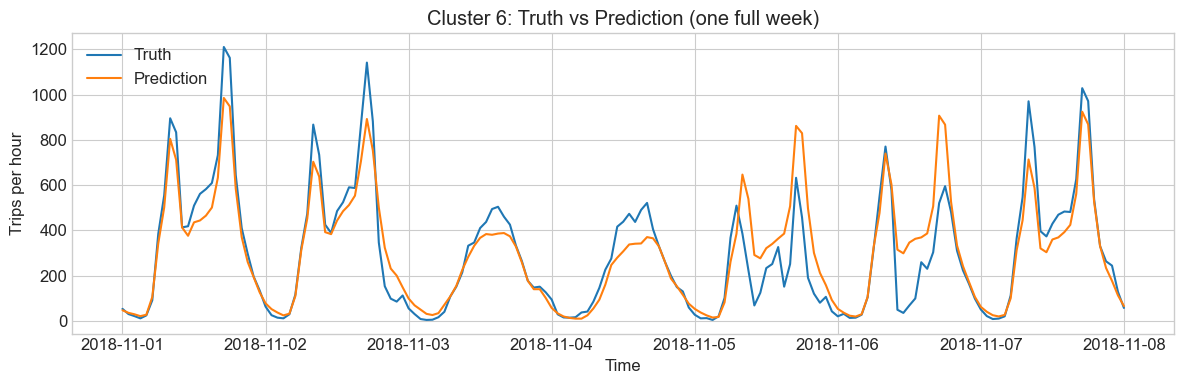

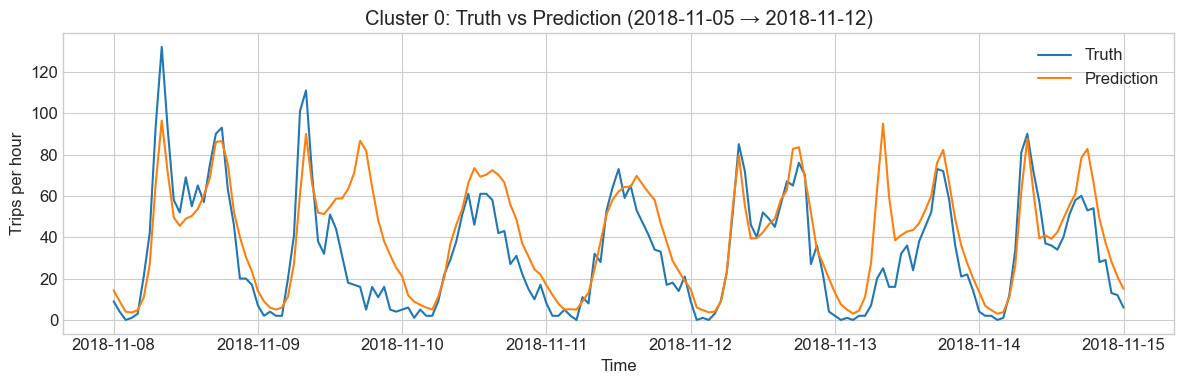

In [60]:
# Rolling 24h ridge forecast per cluster (sequential over days)
LAGS   = [1,2,3,4,6,12,24,48,72,96,168]
RMEANS = [24,168]

def _hour_of_week(ts: pd.Series) -> pd.Series:
    return (ts.dt.dayofweek.astype(int) * 24 + ts.dt.hour.astype(int)).astype("int16")  

def _build_train_matrix(train_df: pd.DataFrame, target: str):
    g = train_df.sort_values(["cluster_id","ts"]).copy()
    g["y"] = g[target].astype(float)
    grp = g.groupby("cluster_id", sort=False)

    for L in LAGS:
        g[f"lag_{L}"] = grp["y"].shift(L)
    for W in RMEANS:
        g[f"rm_{W}"] = grp["y"].transform(lambda s: s.shift(1).rolling(W, min_periods=W).mean())

    g["y_base"] = g["lag_168"]
    g["y_res"]  = g["y"] - g["y_base"]

    g["how"] = _hour_of_week(g["ts"])
    g["is_weekend"] = g["ts"].dt.dayofweek.isin([5,6]).astype("int8")
    g["is_friday"]  = (g["ts"].dt.dayofweek == 4).astype("int8")
    g["is_sunday"]  = (g["ts"].dt.dayofweek == 6).astype("int8")

    g = pd.get_dummies(g, columns=["how"], prefix="how", drop_first=True)

    for base in ["lag_24","lag_168","rm_24","rm_168"]:
        g[f"{base}_wk"] = g[base] * g["is_weekend"]

    X_cols = [c for c in g.columns if c.startswith(("lag_","rm_","how_","is_"))]

    models, how_means, how_p95 = {}, {}, {}
    for cid, sub in g.groupby("cluster_id", sort=False):
        how_idx = (sub["ts"].dt.dayofweek*24 + sub["ts"].dt.hour).astype(int)
        hm  = sub.groupby(how_idx)["y"].mean().to_dict()
        hp  = sub.groupby(how_idx)["y"].quantile(0.95).to_dict()
        cid_int = int(cid)
        how_means[cid_int] = {int(k): float(v) for k,v in hm.items()}
        how_p95[cid_int]   = {int(k): float(v) for k,v in hp.items()}

        core_req = ["lag_24","lag_168","rm_24","rm_168"]
        ok = sub[core_req].notna().all(axis=1)
        if ok.sum() < 300:
            models[cid_int] = None
            continue

        non_core = [c for c in X_cols if c not in core_req]
        sub.loc[:, non_core] = sub.loc[:, non_core].fillna(0.0)

        w = np.where(sub["is_weekend"]==1, 1.8, 1.0).astype("float64")

        alpha = 1.2 if ok.sum() >= 1200 else 2.0
        mdl = Ridge(alpha=alpha)
        mdl.fit(sub.loc[ok, X_cols].to_numpy(dtype="float64"),
                sub.loc[ok, "y_res"].to_numpy(dtype="float64"),
                sample_weight=w[ok])
        models[cid_int] = mdl

    return models, X_cols, how_means, how_p95

def _init_rolling_buffers(hist: pd.Series, t0: pd.Timestamp):
    dq24, dq168 = deque(maxlen=24), deque(maxlen=168)
    s24 = s168 = 0.0
    for k in range(24, 0, -1):
        v = hist.get(t0 - pd.Timedelta(hours=k), np.nan)
        if not np.isnan(v): dq24.append(float(v)); s24 += float(v)
    for k in range(168, 0, -1):
        v = hist.get(t0 - pd.Timedelta(hours=k), np.nan)
        if not np.isnan(v): dq168.append(float(v)); s168 += float(v)
    return dq24, s24, dq168, s168

def _rm_from_buffer(dq, s, W):
    return (s / W) if len(dq) == W else np.nan

def rolling_forecast_24(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str) -> pd.DataFrame:
    models, X_cols, how_means, how_p95 = _build_train_matrix(train_df, target)
    preds = []

    full = pd.concat([train_df[["ts","cluster_id",target]],
                      test_df [["ts","cluster_id",target]]], ignore_index=True)
    clusters = np.sort(test_df["cluster_id"].unique())
    days = pd.to_datetime(test_df["ts"].dt.floor("D").unique())

    how_cols = [c for c in X_cols if c.startswith("how_")]
    core_req = ["lag_24","lag_168","rm_24","rm_168"]

    for cid in clusters:
        cid = int(cid)
        mdl = models.get(cid)
        series = full[full["cluster_id"]==cid].sort_values("ts").set_index("ts")[target].astype(float)
        hist = series.copy()

        t0 = days.min()
        dq24, s24, dq168, s168 = _init_rolling_buffers(hist, t0)

        for d in days:
            for h in range(24):
                t = d + pd.Timedelta(hours=h)

                feats = {}
                how = int(t.dayofweek*24 + t.hour)
                feats[f"how_{how}"] = 1.0
                feats["is_weekend"] = int(t.weekday() >= 5)
                feats["is_friday"]  = int(t.weekday() == 4)
                feats["is_sunday"]  = int(t.weekday() == 6)
                for L in LAGS:
                    feats[f"lag_{L}"] = hist.get(t - pd.Timedelta(hours=L), np.nan)
                feats["rm_24"]  = _rm_from_buffer(dq24,  s24,  24)
                feats["rm_168"] = _rm_from_buffer(dq168, s168, 168)
                feats["lag_24_wk"]  = feats["lag_24"]  * feats["is_weekend"] if not np.isnan(feats["lag_24"])  else np.nan
                feats["lag_168_wk"] = feats["lag_168"] * feats["is_weekend"] if not np.isnan(feats["lag_168"]) else np.nan
                feats["rm_24_wk"]   = feats["rm_24"]   * feats["is_weekend"] if not np.isnan(feats["rm_24"])   else np.nan
                feats["rm_168_wk"]  = feats["rm_168"]  * feats["is_weekend"] if not np.isnan(feats["rm_168"])  else np.nan

                y_base = hist.get(t - pd.Timedelta(hours=168), np.nan)
                if np.isnan(y_base):
                    y_base = how_means.get(cid, {}).get(how, 0.0)

                x = []
                core_missing = False
                for c in X_cols:
                    val = feats.get(c, 0.0 if c.startswith(("how_","is_")) else np.nan)
                    if c in core_req and (not isinstance(val, (int,float)) or np.isnan(val)):
                        core_missing = True
                    x.append(val if not (isinstance(val,float) and np.isnan(val)) else 0.0)
                x = np.asarray(x, dtype="float64")

                if mdl is None or core_missing:
                    yhat = y_base
                else:
                    rhat = float(mdl.predict(x.reshape(1, -1))[0])
                    yhat = y_base + rhat

                cap = how_p95.get(cid, {}).get(how, np.inf)
                yhat = max(0.0, min(yhat, cap))

                preds.append((t, cid, yhat))
                hist.loc[t] = yhat

                if len(dq24) == 24:   s24  -= dq24[0]
                if len(dq168) == 168: s168 -= dq168[0]
                dq24.append(yhat);   s24  += yhat
                dq168.append(yhat); s168 += yhat

    out = (pd.DataFrame(preds, columns=["ts","cluster_id","y_hat"])
             .sort_values(["ts","cluster_id"]).reset_index(drop=True))
    return out

yhat_pickups_24  = rolling_forecast_24(train, test, "pickups")
yhat_dropoffs_24 = rolling_forecast_24(train, test, "dropoffs")

totals_test = (test.assign(total=test["pickups"]+test["dropoffs"])
                    .groupby("cluster_id")["total"].sum())
cid = int(totals_test.sort_values(ascending=False).index[0])

start_week = test["ts"].min().ceil("D")
end_week   = start_week + pd.Timedelta(days=7)

truth = test[(test["cluster_id"]==cid) & (test["ts"].between(start_week, end_week))]        .set_index("ts")["pickups"]
pred  = yhat_pickups_24[(yhat_pickups_24["cluster_id"]==cid) & (yhat_pickups_24["ts"].between(start_week, end_week))]        .set_index("ts")["y_hat"]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(truth.index, truth.values, label="Truth")
ax.plot(pred.index,  pred.values,  label="Prediction")
ax.set_title(f"Cluster {cid}: Truth vs Prediction (one full week)")
ax.set_xlabel("Time"); ax.set_ylabel("Trips per hour")
ax.legend()
plt.tight_layout()
plt.show()

cid_custom = 0
start_custom = pd.Timestamp("2018-11-08")
end_custom   = pd.Timestamp("2018-11-15")

truth0 = (test
          .loc[(test["cluster_id"]==cid_custom) & (test["ts"].between(start_custom, end_custom))]
          .set_index("ts")["pickups"])
pred0  = (yhat_pickups_24
          .loc[(yhat_pickups_24["cluster_id"]==cid_custom) & (yhat_pickups_24["ts"].between(start_custom, end_custom))]
          .set_index("ts")["y_hat"])

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(truth0.index, truth0.values, label="Truth")
ax.plot(pred0.index,  pred0.values,  label="Prediction")
ax.set_title("Cluster 0: Truth vs Prediction (2018-11-05 → 2018-11-12)")
ax.set_xlabel("Time"); ax.set_ylabel("Trips per hour")
ax.legend()
plt.tight_layout()
plt.show()


### 2.9 Rebalancing analysis

Translate predicted flows into staging needs.


In [61]:
# RF-style metrics (MAE/RMSE/WAPE/MAPE).

def rf_style_metrics(test_df, pred_df, target, cluster_ids=None, aggregate_citywide=False):
    df = test_df[["ts", "cluster_id", target]].merge(
        pred_df[["ts", "cluster_id", "y_hat"]],
        on=["ts", "cluster_id"],
        how="inner",
    )
    if cluster_ids is not None:
        df = df[df["cluster_id"].isin(cluster_ids)]
    df["y_hat"] = df["y_hat"].clip(lower=0)
    if aggregate_citywide:
        df = df.groupby("ts", as_index=False).agg({target: "sum", "y_hat": "sum"})

    y = df[target].to_numpy(dtype="float64")
    yhat = df["y_hat"].to_numpy(dtype="float64")
    e = y - yhat

    mae = float(np.mean(np.abs(e)))
    rmse = float(np.sqrt(np.mean(e ** 2)))
    wape = float(np.sum(np.abs(e)) / max(1e-9, np.sum(y)))
    mape = float(np.mean(np.abs(e) / np.where(y == 0, 1e-9, y))) * 100
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape, "MAPE_pct": mape}

print("Test metrics (Nov–Dec 2018) — pickups, aggregated like exploratory RF:")
print("  Citywide (sum over clusters):", rf_style_metrics(test, yhat_pickups_24, "pickups", aggregate_citywide=True))
print("  Cluster 0:", rf_style_metrics(test, yhat_pickups_24, "pickups", cluster_ids=[0]))
print("  Cluster 6:", rf_style_metrics(test, yhat_pickups_24, "pickups", cluster_ids=[6]))


Test metrics (Nov–Dec 2018) — pickups, aggregated like exploratory RF:
  Citywide (sum over clusters): {'MAE': 680.3837451854841, 'RMSE': 1104.1670765652475, 'WAPE': 0.43751295320776895, 'MAPE_pct': 120.5042843360211}
  Cluster 0: {'MAE': 12.074804549379845, 'RMSE': 17.64387530189174, 'WAPE': 0.43094865578479014, 'MAPE_pct': 18271144173.483047}
  Cluster 6: {'MAE': 86.91031550659558, 'RMSE': 148.69342450574737, 'WAPE': 0.41117046987124234, 'MAPE_pct': 978077291.7171068}


### 2.9 Metrics snapshots

Quick error summaries for citywide and key clusters.


In [62]:
# Quick metrics snapshots
def compute_metrics(test_df, pred_df, target, cluster_ids=None):
    df = test_df[["ts","cluster_id",target]].merge(
        pred_df[["ts","cluster_id","y_hat"]],
        on=["ts","cluster_id"],
        how="inner",
    )
    if cluster_ids is not None:
        df = df[df["cluster_id"].isin(cluster_ids)]
    y = df[target].astype(float).to_numpy()
    yhat = df["y_hat"].astype(float).clip(lower=0).to_numpy()
    e = y - yhat
    mae = float(np.mean(np.abs(e)))
    rmse = float(np.sqrt(np.mean(e**2)))
    wape = float(np.sum(np.abs(e)) / max(1e-9, np.sum(y)))
    mape = float(np.mean(np.abs(e) / np.where(y == 0, 1e-9, y))) * 100
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape, "MAPE_pct": mape}

print("Citywide pickups:", compute_metrics(test, yhat_pickups_24, "pickups"))
print("Citywide dropoffs:", compute_metrics(test, yhat_dropoffs_24, "dropoffs"))
print("Cluster 0 pickups:", compute_metrics(test, yhat_pickups_24, "pickups", [0]))
print("Cluster 6 pickups:", compute_metrics(test, yhat_pickups_24, "pickups", [6]))
print("Cluster 0 dropoffs:", compute_metrics(test, yhat_dropoffs_24, "dropoffs", [0]))
print("Cluster 6 dropoffs:", compute_metrics(test, yhat_dropoffs_24, "dropoffs", [6]))


Citywide pickups: {'MAE': 29.992605508715904, 'RMSE': 69.6172011749449, 'WAPE': 0.46287361225315254, 'MAPE_pct': 15100766983.821424}
Citywide dropoffs: {'MAE': 29.84478679020965, 'RMSE': 69.1192790692487, 'WAPE': 0.46054985643240803, 'MAPE_pct': 14856561888.612848}
Cluster 0 pickups: {'MAE': 12.074804549379845, 'RMSE': 17.64387530189174, 'WAPE': 0.43094865578479014, 'MAPE_pct': 18271144173.483047}
Cluster 6 pickups: {'MAE': 86.91031550659558, 'RMSE': 148.69342450574737, 'WAPE': 0.41117046987124234, 'MAPE_pct': 978077291.7171068}
Cluster 0 dropoffs: {'MAE': 12.675876923318897, 'RMSE': 18.474538137070684, 'WAPE': 0.4456113294690567, 'MAPE_pct': 20411492452.420753}
Cluster 6 dropoffs: {'MAE': 85.99741358307506, 'RMSE': 148.94012435934633, 'WAPE': 0.4065940250661138, 'MAPE_pct': 142.20337413717698}


### 2.10 Rebalancing analysis

Translate predicted flows into staging needs.

In [63]:
# Rebalancing optimization setup
analysis_day = '2018-11-07' 
day_mask = (y_test.index.strftime('%Y-%m-%d') == analysis_day)

pred_arrivals = y_pred_drop[day_mask]
pred_departures = y_pred[day_mask]
hours = y_test.index[day_mask]

net_flow = pred_arrivals - pred_departures
cumulative_inventory = np.cumsum(net_flow)
min_inventory = np.min(cumulative_inventory)
bikes_needed = abs(min(0, min_inventory))

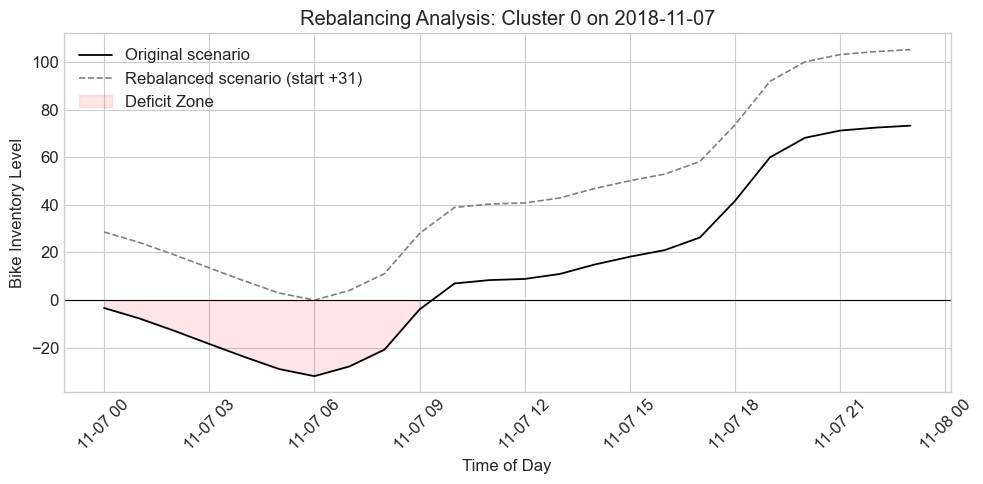

In [64]:
# --- VISUALIZATION: REBALANCING ---

df_rebal = pd.DataFrame({
    'Hour': hours,
    'Net_Flow': net_flow,
    'Inventory_Change': cumulative_inventory
})

# Safe inventory
df_rebal['Safe_Inventory'] = df_rebal['Inventory_Change'] + bikes_needed

plt.figure(figsize=(10, 5)) # Slightly wider for clarity

plt.plot(
    df_rebal['Hour'],
    df_rebal['Inventory_Change'],
    label='Original scenario',
    color='black',
    linewidth=1.3,
)

plt.plot(
    df_rebal['Hour'],
    df_rebal['Safe_Inventory'],
    label=f'Rebalanced scenario (start +{int(bikes_needed)})',
    color='gray',
    linestyle='--',
    linewidth=1.2,
)

plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

plt.fill_between(df_rebal['Hour'], df_rebal['Inventory_Change'], 0,
                 where=(df_rebal['Inventory_Change'] < 0),
                 color='red', alpha=0.1, label='Deficit Zone')

plt.title(f"Rebalancing Analysis: Cluster {target_cluster} on {analysis_day}")
plt.ylabel("Bike Inventory Level")
plt.xlabel("Time of Day")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
